# Training, Engineering, and Model Assesment

## Import packages 

In [57]:
# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import  randint
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import learning_curve



# plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Import Data

In [58]:
# set target (what are we trying to predict)
target = 'pwt_500hpa'

In [ ]:
# set lists of coordinates and time ranges (pulled from Prepare_AI_Ready_Data.py)
coords = [[180,240,45,65],[130,250,20,75]]
times = [['1970-01-01','2023-12-31']]  # Ensure the time range is valid

# set PC option - seperate or combined
#PC_option = 'combined'
PC_option = 'seperate'

# select which of the list I want to load
coords_num = 1
times_num = 0

# pull the correct coordinate and time (as set above)
c = coords[coords_num]
t = times[times_num]

# read in PCs
if PC_option == 'combined':
    raw_data = pd.read_csv(f'../data/dimensionality_reduction/principal_components_combined_{c[0]}-{c[1]}_{c[2]}-{c[3]}_{t[0][:4]}-{t[1][:4]}_target.csv')
elif PC_option == 'seperate':
    raw_data = pd.read_csv(f'../data/dimensionality_reduction/principal_components_seperate_{c[0]}-{c[1]}_{c[2]}-{c[3]}_{t[0][:4]}-{t[1][:4]}_target.csv')

In [60]:
# Keep only columns that are target, contain "PC", or contain "month"
columns_to_keep = [col for col in raw_data.columns if target in col or "PC" in col or "month" in col]
data = raw_data[columns_to_keep]

# normalize all float columns to vary between 0 and 1, but ignore boolean columns
for col in data.columns:
    if data[col].dtype == 'float64':
        data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

data.head()

/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_55335/279490208.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())


,PC1_sst,PC2_sst,PC3_sst,PC4_sst,PC5_sst,PC6_sst,PC7_sst,PC8_sst,PC9_sst,PC10_sst,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0.259173,0.635995,0.431253,0.605195,0.468394,0.450963,0.552845,0.414452,0.499316,0.399609,...,False,False,False,False,False,False,False,False,False,False
1,0.297425,0.604696,0.368090,0.608731,0.524775,0.468598,0.522726,0.454354,0.549438,0.483807,...,False,False,False,False,False,False,False,False,False,False
2,0.291333,0.660220,0.374712,0.550507,0.359033,0.560825,0.511349,0.435851,0.573838,0.458497,...,True,False,False,False,False,False,False,False,False,False
3,0.310941,0.518791,0.416521,0.411727,0.288424,0.633701,0.453706,0.457244,0.544118,0.454177,...,False,True,False,False,False,False,False,False,False,False
4,0.314177,0.318119,0.427844,0.399218,0.347708,0.638117,0.574364,0.388460,0.519845,0.464419,...,False,False,True,False,False,False,False,False,False,False


## Linear Regression

While the preformance of all of the models in AutoML wasn't fantstic, the linear regression approach was near the top of the list. And, this is the simplest approach (hyperparameter tunning doesn't even apply, as there aren't that many parameters).

In [61]:
# Splitting the data into independent and dependent variables
#X = data[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8','PC9','PC10', 'month']]
#Y = data['pwt_500hpa']
Y = data[target]
X = data.drop(columns=[target])

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42
)


# Fitting the model
t1 = time.perf_counter()
regressor = LinearRegression()
regressor.fit(X_train, y_train)
t2 = time.perf_counter()
t_lr_onerun = t2-t1

# Calculating the test set results
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"mean square error {mse} and R2 {r2}")


mean square error 0.02186008726138314 and R2 0.12167551385488118


### Linear Regression - k-fold cross validation

Here we'll use k-fold cross validation to robustly estimate the accuracy of this model. Our runtime is fast enough we could use something even more accruate, like leave one out cross validation. However, this takes too long further down, and I want to stay consistent with my assesment approach accross models.

In [62]:
# now let's impliment a k-fold cross validation of the linear regression model

# Start timer
t1 = time.perf_counter()

# Initialize KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(
    regressor,
    X,
    Y,
    cv=kfold,
    scoring='r2',
    n_jobs=-1
)

# End timer
t2 = time.perf_counter()
t_lr_kfold = t2 - t1

# calculate mae, mse, and rmse
mae = -cross_val_score(regressor, X, Y, cv=kfold, scoring='neg_mean_absolute_error').mean()
mse = -cross_val_score(regressor, X, Y, cv=kfold, scoring='neg_mean_squared_error').mean()

# Store results
results = {
    'model': 'LinearRegression',
    'mean_r2': scores.mean(),
    'std_r2': scores.std(),
    'mean_absolute_error': mae,
    'mean_squared_error': mse,
    'root_mean_squared_error': np.sqrt(mse),
    '1 Run Time': t_lr_onerun,
    'K-Fold Time': t_lr_kfold
}

# Print results
for key, value in results.items():
    print(key + ':', value)

# Convert results to DataFrame and append to results_df
results_df = pd.DataFrame(results, index=[0])


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Linear Regression - Learning Curve

We can use this to get a sense for how the model training responds to different training sizes. There's a lot of noise here, pointing to the model being very sensitive to the training subset. Absolute preformance is also, of course, quite low. Even the training score is low, even at higher sample numbers. This might towards difficultly fitting with a purely linear approach.

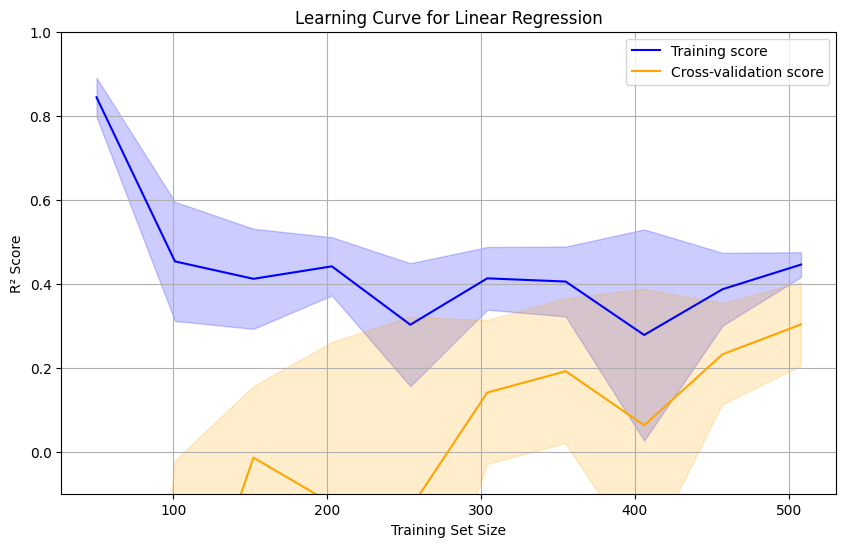

In [63]:
# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    regressor, X, Y, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color="blue")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="blue")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color="orange")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="orange")
plt.title("Learning Curve for Linear Regression")
plt.ylim(-0.1, 1)
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend(loc="best")
plt.grid()
plt.show()

As expected, the preformance of the linear regression above is pretty weak. Now let's try modifying the 'month' column to give this a chance - we'll make it months from the hotest month time of year (July/August). July/August will be a '0', June/Sepetember a 1, and so on

Wow, this was a big improvement! We jumped from r^2 <0.1 to r^2 ~ 0.65. This points to the importance of having a physically interpretable month. However, this r^2 value is still significantly worse than what I was achieving in the auto_ml notebook. Rather than further develop/test the linear model, I'm going to switch to some more complex approaches to see what I can do.

## Random Forest Regression

Here I train a random forest regression. While this wasn't the top-preforming approach in the AutoML methods, it is a commonly used method in the geosciences. The interpretability of this model makes it worthwhile to consider for our application. Likewise, I'm keen to explore an approach which is able to handle non-linear relationships.

Note that I've already preformed onehot encoding on the month column before starting here, so the month data is included as a set of 12 boolean variables.

### Random Forest - First Pass

Here I'll just do a simple first pass, giving us a sense of the accuracy and runtime of this approach.

In [64]:
# Labels are the values we want to predict
labels = np.array(data[target])

# Remove the labels from the features
# axis 1 refers to the columns
features = data.drop(columns=[target])

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

# split the data into test/training sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3, random_state = 42)

# establish the model baseline. We'll make averages over the time the baseline prediction
baseline_preds = np.mean(test_labels)

In [65]:
# start timer
t1 = time.perf_counter()

# initalize the model
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels)

# save training time
t2 = time.perf_counter()
print(f"Training time: {t2-t1} seconds")
t_rf = t2-t1

# print basic metrics about the model
predictions = rf.predict(test_features)
errors = abs(predictions - test_labels)
mae = round(np.mean(errors), 2)
mse = mean_squared_error(test_labels, predictions)
r2 = r2_score(test_labels, predictions)
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('R²:', r2)

Training time: 5.955610124976374 seconds
Mean Absolute Error: 0.11
Mean Squared Error: 0.02050846687996687
R²: 0.17598276628144827


### Random Forest - Hyperparameter Training

We're off to a start - we've learned this model is fast, but the time is not negligibly so at 3s (a ton of folds could add up). Preformance seems fairly weak, but we may be able to improve slightly with better taining

Here we explore varying:
- The number of estimators (trees in the forstest), four options between 100 and 1000. More should be better, but with diminishing yield and risk of overfitting
- The maximum depth of the tree, from 10 to 30, plus a 'None' option. Some risk of overfitting as we get too deep.
- The Maximum number of features considered at each split. I consider a range of approaches, including considering everything (1.0) to 1 (1), along with 'sqrt' and 'log2' which are standard in-between approaches.
- The minimum samples  to split an internal node. I used chatGPT to guide me to a reasonable range here.
The minimum samples in a leaf node. 
- I also toggle bootstrapping on/off, setting if I draw samples with replacement while training each tree.

In [66]:
t1 = time.perf_counter()

# Define a parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [10, 20, 30, None],
    'max_features': ['sqrt','log2',1,1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the random forest regressor
rf = RandomForestRegressor(random_state=42)

# Set up the RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=20,
    cv=5,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

# Run the hyperparameter search
rf_random.fit(features, labels)

# store time
t2 = time.perf_counter()
t_rf_hyperparam = t2-t1

# Print the best parameters and score
print("Best Parameters:", rf_random.best_params_)
print("Best CV Score:", rf_random.best_score_)
print("R^2 of the best estimator:", rf_random.best_estimator_.score(test_features, test_labels))

# Retrieve the best model
best_rf_model = rf_random.best_estimator_


# store parameters in a way they can be used in k-fold cross validation below.
n_estimators = best_rf_model.get_params()['n_estimators']
max_depth = best_rf_model.get_params()['max_depth']
max_features = best_rf_model.get_params()['max_features']
min_samples_split = best_rf_model.get_params()['min_samples_split']
min_samples_leaf = best_rf_model.get_params()['min_samples_leaf']
bootstrap = best_rf_model.get_params()['bootstrap']


Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 1.0, 'max_depth': None, 'bootstrap': True}
Best CV Score: 0.23211864541116486
R^2 of the best estimator: 0.8718728977997494


### Random Forest - K-fold cross validation

Now that we've assessed a single model, let's do a more comprehensive analysis.

My gut here is to do a leave out cross validation. We have a relatively small dataset, and might be able to get away with this computationally intensive approach. However, if we take the runtime (~3s) and the number of samples (~640) we quickly realize this puts us at a total runtime of over 30 minutes. Whoops - that's too much for our purposes.

Instead, let's use a K-fold cross validation. We'll get many of the same benefits, including a very (but slightly less) accurate picture of our predictive accuracy, but with less computational effort.



In [67]:
from sklearn.model_selection import KFold, cross_val_score

t1 = time.perf_counter()

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(
    best_rf_model,
    features,
    labels,
    cv=kfold,
    scoring='r2',
    n_jobs=-1
)

t2 = time.perf_counter()
t_rf_kfold = t2-t1

# Add Random Forest results to the results_df
rf_results = {
    'model': 'RandomForestRegressor',
    'mean_r2': scores.mean(),
    'std_r2': scores.std(),
    'mean_absolute_error': mae,
    'mean_squared_error': mse,
    'root_mean_squared_error': np.sqrt(mse),
    '1 Run Time': t_rf,
    'K-Fold Time': t_rf_kfold,
    'Hyperparameter Time': t_rf_hyperparam
}

df = pd.DataFrame(rf_results, index=[0])

# combine with existing results_df
results_df = pd.concat([results_df, df], axis=0)

### Random Forest - Learning Curve

There's quite a large gap here between the training score (impresive) and the cross validation score (poor). We don't seem to be improving much with imcreasing sample size at this scale.

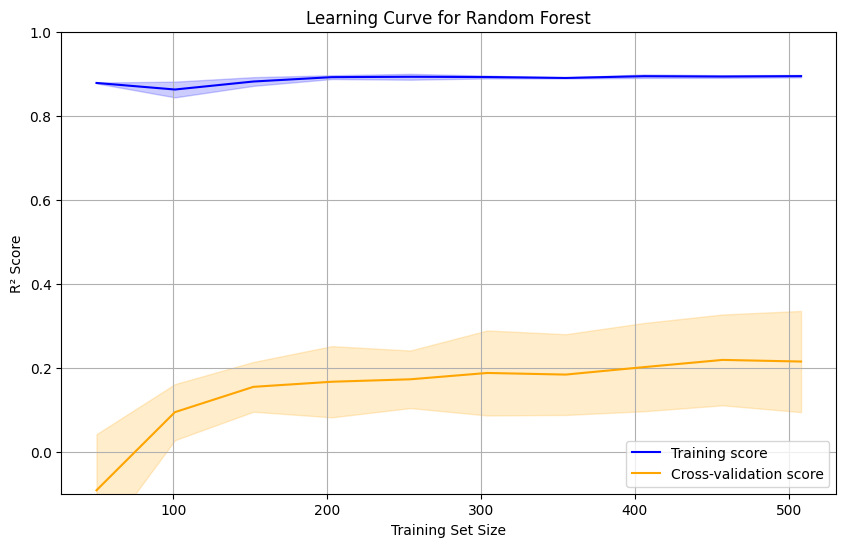

In [68]:
# Generate learning curve data for the random forest model
train_sizes, train_scores, test_scores = learning_curve(
    rf, features, labels, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color="blue")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="blue")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color="orange")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="orange")
plt.title("Learning Curve for Random Forest")
plt.ylim(-0.1, 1)
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend(loc="best")
plt.grid()
plt.show()

### Random Forest - Interpretibility

/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_55335/407757109.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


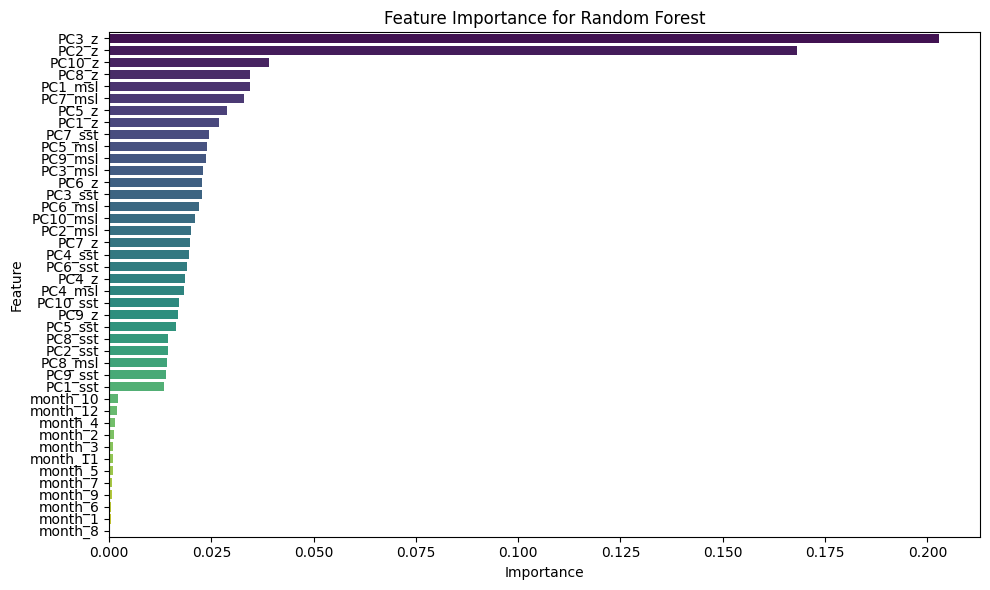

In [69]:
# Extract feature importances
importances = best_rf_model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_list,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance for Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [70]:
results_df

,model,mean_r2,std_r2,mean_absolute_error,mean_squared_error,root_mean_squared_error,1 Run Time,K-Fold Time,Hyperparameter Time
0,LinearRegression,0.269172,0.155081,0.105245,0.019269,0.138814,0.037555,7.393572,NaN
0,RandomForestRegressor,0.256013,0.062276,0.110000,0.020508,0.143208,5.955610,5.326381,21.417977


## Huber Regressor

This was the top-preforming model in my autoML approach. This may be due to the huber regressor's robust handling of outliers, which is a particular strength of the model. It is also fairly strightforward, with good ability to handle complex data.

I'll start with a simple implimentation of the approach, to get a sense of runtime and rough preformance.

In [71]:

# Initial Model Run
t1 = time.perf_counter()
huber = HuberRegressor()
huber.fit(train_features, train_labels)
y_pred = huber.predict(test_features)
t2 = time.perf_counter()
t_huber_onerun = t2-t1

# Calculate metrics
mse = mean_squared_error(test_labels, y_pred)
mae = mean_absolute_error(test_labels, y_pred)
r2 = r2_score(test_labels, y_pred)
print(f"Initial Model - MSE: {mse}, MAE: {mae}, R2: {r2}, Training Time: {t2 - t1} seconds")

Initial Model - MSE: 0.020053325000540384, MAE: 0.11059086131097565, R2: 0.1942700792546489, Training Time: 0.02142795897088945 seconds


/Users/Liam/anaconda3/envs/ess469_final/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### Huber Regressor - Hyperparameter Tuning

- Epsilon, which controls the number of outliers the model can handle. Smaller values make the model less robust to outliers.
-  Regularization strength, where higher values add more penalty to the model complexity, preventing overfitting.
-  The aximum number of iterations for the optimization algorithm, ensuring convergence (some of these selections result in warning messages while running)

In [72]:
# Hyperparameter Tuning
param_distributions = {
    'epsilon': [1.1, 1.2, 1.3, 1.35, 1.4, 1.5],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'max_iter': [100, 200, 500, 1000]
}

t1 = time.perf_counter()
huber_random = RandomizedSearchCV(
    estimator=HuberRegressor(),
    param_distributions=param_distributions,
    n_iter=20,
    cv=5,
    verbose=0,
    random_state=42,
    n_jobs=-1
)
huber_random.fit(train_features, train_labels)
t2 = time.perf_counter()
t_huber_hyperparam = t2-t1

# Best model and metrics
best_huber_model = huber_random.best_estimator_
best_params = huber_random.best_params_
print(f"Best Parameters: {best_params}")
print(f"R^2 of the best estimator: {best_huber_model.score(test_features, test_labels)}")
print(f"Hyperparameter Tuning Time: {t2 - t1} seconds")

/Users/Liam/anaconda3/envs/ess469_final/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/Liam/anaconda3/envs/ess469_final/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/Liam/anaconda3/envs/ess469_final/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1)

Best Parameters: {'max_iter': 100, 'epsilon': 1.35, 'alpha': 0.001}
R^2 of the best estimator: 0.19366540622172423
Hyperparameter Tuning Time: 0.5607579159550369 seconds


/Users/Liam/anaconda3/envs/ess469_final/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/Liam/anaconda3/envs/ess469_final/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/Liam/anaconda3/envs/ess469_final/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1)

### Huber Regression - K-Fold Cross Validation

Here I just follow the same methods as above with the linear regression and random forest.

In [ ]:

t1 = time.perf_counter()
# K-Fold Analysis
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(
    best_huber_model,
    features,
    labels,
    cv=kfold,
    scoring='r2',
    n_jobs=-1
)
t2 = time.perf_counter()
t_huber_kfold = t2-t1

# calculate mae, mse
y_pred = best_huber_model.predict(test_features)
mse = mean_squared_error(test_labels, y_pred)
mae = mean_absolute_error(test_labels, y_pred)

# Store results
results = {
    'model': 'HuberRegressor',
    'best_params': best_params,
    'mean_r2': scores.mean(),
    'std_r2': scores.std(),
    'mean_absolute_error': mae,
    'mean_squared_error': mse,
    'root_mean_squared_error': np.sqrt(mse),
    '1 Run Time': t_huber_onerun,
    'Hyperparameter Time': t_huber_hyperparam,
    'K-Fold Time': t_huber_kfold
}

# Print results
for key, value in results.items():
    print(key + ':', value)

df = pd.DataFrame(results, index=[0])

# combine with existing results_df
results_df = pd.concat([results_df, df], axis=0)

model: HuberRegressor
best_params: {'max_iter': 100, 'epsilon': 1.35, 'alpha': 0.001}
mean_r2: 0.33142937665223
std_r2: 0.0959178016044047
mean_absolute_error: 0.11053427742675755
mean_squared_error: 0.020068374342182164
root_mean_squared_error: 0.14166288978480626
1 Run Time: 0.02142795897088945
Hyperparameter Time: 0.5607579159550369
K-Fold Time: 0.06690779200289398


/Users/Liam/anaconda3/envs/ess469_final/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/Liam/anaconda3/envs/ess469_final/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/Liam/anaconda3/envs/ess469_final/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1)

### Huber Regressor - Learning Curve

Again, plotting a learning curve to understand results

/Users/Liam/anaconda3/envs/ess469_final/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/Liam/anaconda3/envs/ess469_final/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/Liam/anaconda3/envs/ess469_final/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1)

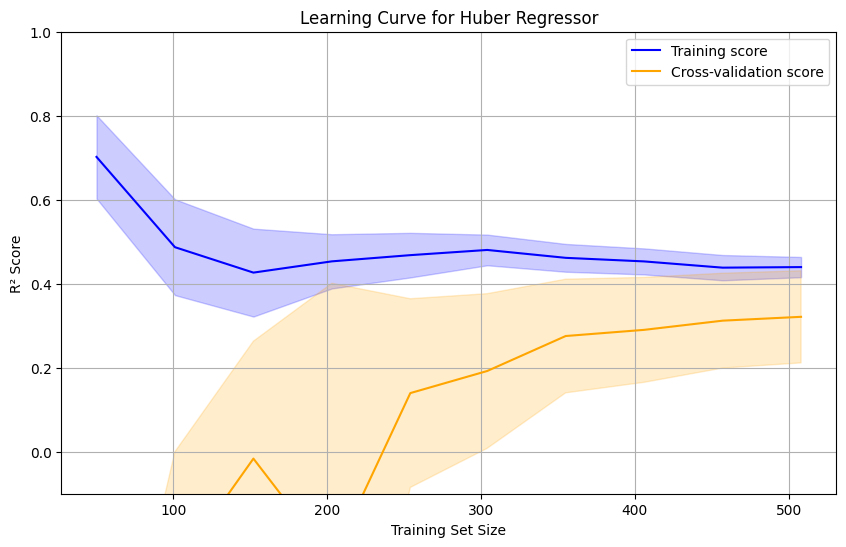

In [74]:
# Generate learning curve data for the Huber Regressor
train_sizes, train_scores, test_scores = learning_curve(
    best_huber_model, features, labels, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color="blue")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="blue")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color="orange")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="orange")
plt.title("Learning Curve for Huber Regressor")
plt.ylim(-0.1, 1)
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend(loc="best")
plt.grid()
plt.show()

### Huber Regressor - Feature Importance

Here I visualize the feature importance of the Huber Regressor. Since Huber Regressor does not provide feature importances directly, we can use the coefficients as a proxy for feature importance.

/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_55335/2296813284.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


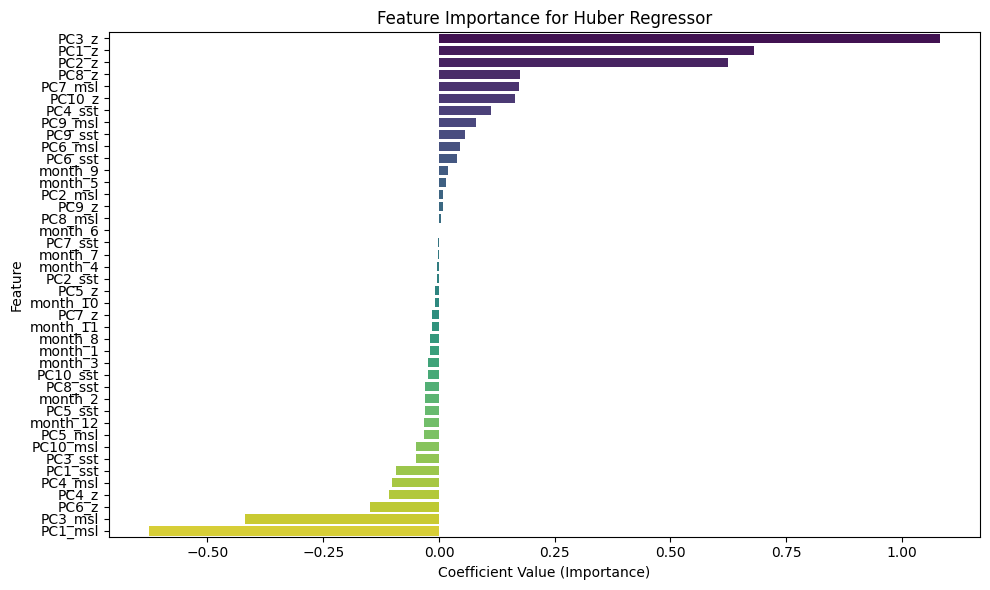

In [75]:


# Extract feature importance (coefficients)
feature_importances = best_huber_model.coef_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_list,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance for Huber Regressor')
plt.xlabel('Coefficient Value (Importance)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


## Comparison

Here I compare the preformance of all three models on a single plot.

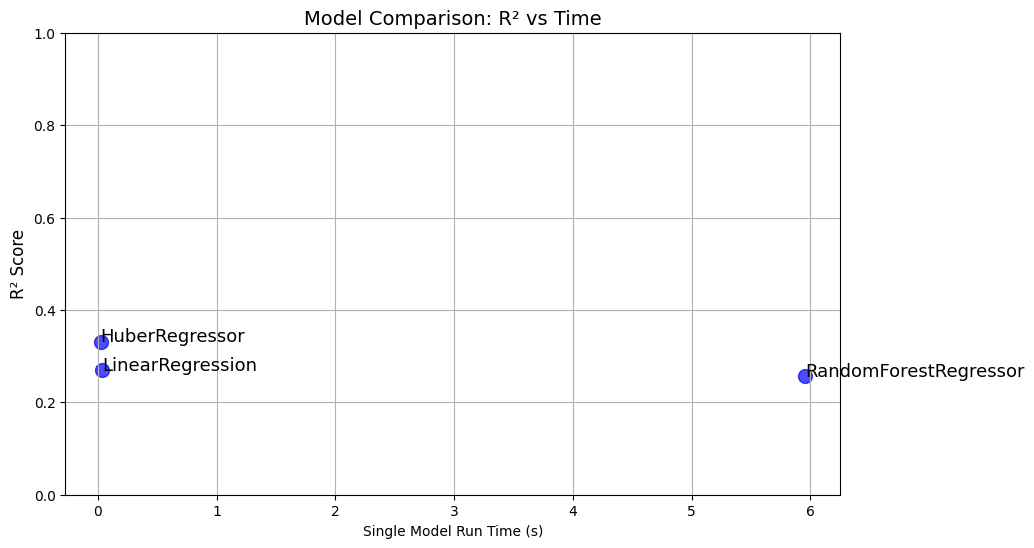

In [76]:


# Extract relevant data for plotting
models = results_df['model']
r2_scores = results_df['mean_r2']
times = results_df['1 Run Time']
#times = results_df['Hyperparameter Time'].fillna(0) + results_df['K-Fold Time']

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(times, r2_scores, color='blue', s=100, alpha=0.7)

# Annotate each point with the model name
for i, model in enumerate(models):
    plt.text(times.iloc[i], r2_scores.iloc[i], model, fontsize=13, ha='left')

# Add labels and title
plt.title('Model Comparison: R² vs Time', fontsize=14)
plt.xlabel('Single Model Run Time (s)')
#plt.xlabel('Time (Hyperparameter + K-Fold) [seconds]', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.grid(True)
plt.ylim(0, 1)
plt.show()


In [80]:
# save the results
results_df.to_csv('../data/results/CML_results.csv', index=False)

### Huber Regressor, applied to Temperature data

Here, I check the preformance of the Huber regresssor when applied to temperature data instead of temperature. I just copy code from above. 

In [78]:
# set target
target = 'temperature_500hpa'

# Keep only columns that are target, contain "PC", or contain "month"
columns_to_keep = [col for col in raw_data.columns if target in col or "PC" in col or "month" in col]
data_temp = raw_data[columns_to_keep]

# normalize all float columns to vary between 0 and 1, but ignore boolean columns
for col in data_temp.columns:
    if data_temp[col].dtype == 'float64':
        data_temp[col] = (data_temp[col] - data_temp[col].min()) / (data_temp[col].max() - data_temp[col].min())

# break out features and labels

labels = np.array(data_temp[target])
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3, random_state = 42)

# Hyperparameter Tuning
param_distributions = {
    'epsilon': [1.1, 1.2, 1.3, 1.35, 1.4, 1.5],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'max_iter': [100, 200, 500, 1000]
}

t1 = time.perf_counter()
huber_random = RandomizedSearchCV(
    estimator=HuberRegressor(),
    param_distributions=param_distributions,
    n_iter=20,
    cv=5,
    verbose=0,
    random_state=42,
    n_jobs=-1
)
huber_random.fit(train_features, train_labels)
t2 = time.perf_counter()
t_huber_hyperparam = t2-t1

# Best model and metrics
best_huber_model_temp = huber_random.best_estimator_
best_params = huber_random.best_params_
print(f"Best Parameters: {best_params}")
print(f"R^2 of the best estimator: {best_huber_model_temp.score(test_features, test_labels)}")
print(f"Hyperparameter Tuning Time: {t2 - t1} seconds")

# K-Fold Analysis
t1 = time.perf_counter()
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(
    best_huber_model_temp,
    features,
    labels,
    cv=kfold,
    scoring='r2',
    n_jobs=-1
)
t2 = time.perf_counter()
t_huber_kfold = t2-t1

# calculate mae, mse
y_pred = best_huber_model_temp.predict(test_features)
mse = mean_squared_error(test_labels, y_pred)
mae = mean_absolute_error(test_labels, y_pred)

# Store results
results = {
    'model': 'HuberRegressor-temperature_500hpa',
    'best_params': best_params,
    'mean_r2': scores.mean(),
    'std_r2': scores.std(),
    'mean_absolute_error': mae,
    'mean_squared_error': mse,
    'root_mean_squared_error': np.sqrt(mse),
    'Hyperparameter Time': t_huber_hyperparam,
    'K-Fold Time': t_huber_kfold
}

# Print results
for key, value in results.items():
    print(key + ':', value)

df = pd.DataFrame(results, index=[0])



/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_55335/806032875.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp[col] = (data_temp[col] - data_temp[col].min()) / (data_temp[col].max() - data_temp[col].min())
/Users/Liam/anaconda3/envs/ess469_final/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/Liam/anaconda3/envs/ess469_final/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342

Best Parameters: {'max_iter': 1000, 'epsilon': 1.5, 'alpha': 0.001}
R^2 of the best estimator: 0.8641597524269421
Hyperparameter Tuning Time: 0.6338555830297992 seconds
model: HuberRegressor-temperature_500hpa
best_params: {'max_iter': 1000, 'epsilon': 1.5, 'alpha': 0.001}
mean_r2: 0.8619033042827375
std_r2: 0.024169764811314793
mean_absolute_error: 0.04240827114251936
mean_squared_error: 0.002834960819610535
root_mean_squared_error: 0.05324435011914912
Hyperparameter Time: 0.6338555830297992
K-Fold Time: 0.07947420899290591


/Users/Liam/anaconda3/envs/ess469_final/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/Liam/anaconda3/envs/ess469_final/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/Liam/anaconda3/envs/ess469_final/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1)

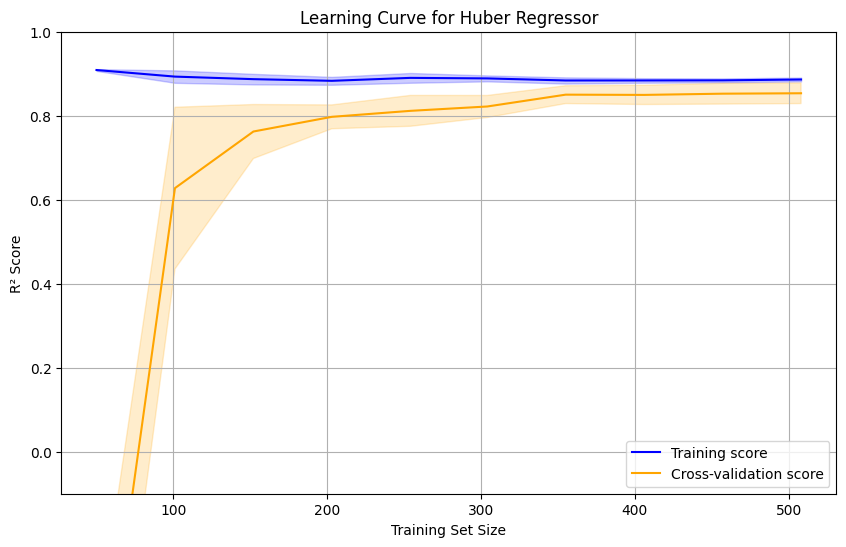

In [79]:
# Generate learning curve data for the Huber Regressor
train_sizes, train_scores, test_scores = learning_curve(
    best_huber_model_temp, features, labels, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color="blue")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="blue")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color="orange")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="orange")
plt.title("Learning Curve for Huber Regressor")
plt.ylim(-0.1, 1)
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend(loc="best")
plt.grid()
plt.show()
